In [4]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph

# Parameters

In [5]:
iteration = 3
PhenoGraph_k =  100
PopulationGraph_type = 'complete_graph_with_weak_edges_removed'
para_dict = {
    'weight_threshold_percentile': 90,
    'knn_k':10
}

# Load data

##### pattern feature and ids

In [6]:
FILE_NAMES = os.listdir(
    os.path.join(PROJECT_ROOT, "Output", "b_Soft_WL_Kernel", "Danenberg", "Cohort_1", 'Subtrees')
)
X = []
Cluster_identities = []
Indices = []
for i in range(len(FILE_NAMES)):
    file_name = FILE_NAMES[i]
    x = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Danenberg",
            "Cohort_1",
            "Subtrees",
            file_name,
            "neighborhood_aggregation",
            "X" + str(iteration) + ".npy",
        )
    )
    cluster_identities = np.load(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Danenberg",
            "Cohort_1",
            "Subtrees",
            file_name,
            "pattern_ids",
            "pattern_id_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + ".npy",
        )
    )
    indices = np.zeros(x.shape[0], dtype=int)
    indices[:] = i

    Indices.append(indices)
    X.append(x)
    Cluster_identities.append(cluster_identities)
X = np.concatenate(X, axis=0)
Cluster_identities = np.concatenate(Cluster_identities, axis=0)
Indices = np.concatenate(Indices, axis=0)

#### Gram matrix

In [3]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Danenberg",
            "Cohort_1",
            "SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Gram_matrix = SoftWL_dict["Gram_matrix"]
Histograms = SoftWL_dict["Histogram"]

G_population = construct_PopulationGraph(
    Gram_matrix,
    PopulationGraph_type,
    para_dict = para_dict,
)


NameError: name 'pickle' is not defined

#### Clinical

In [20]:
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical.head()

,Unnamed: 0,metabric_id,patient_id,Cohort,Overall Survival (Months),Overall Survival Status,Relapse Free Status (Months),Relapse Free Status,Chemotherapy,Radio Therapy,...,Disease-specific Survival (Months),Disease-specific Survival Status,ERStatus,ERBB2_pos,Grade,sizeOrdinal,LymphNodesOrdinal,PAM50,isDiscovery,IntClust
0,1,MB-0002,2,1.0,84.633333,0:LIVING,83.52,0:Not Recurred,NO,YES,...,83.416838,0:LIVING,pos,False,3.0,5-10mm,0,Luminal A,True,IntClust 4+
1,2,MB-0005,5,1.0,163.700000,1:DECEASED,151.28,1:Recurred,YES,NO,...,161.347023,1:DECEASED,pos,False,2.0,10-20mm,1,Luminal B,True,IntClust 3
2,3,MB-0006,6,1.0,164.933333,0:LIVING,162.76,0:Not Recurred,YES,YES,...,162.562628,0:LIVING,pos,False,2.0,20-50mm,2-3,Luminal B,True,IntClust 9
3,5,MB-0010,10,1.0,7.800000,1:DECEASED,2.89,1:Recurred,NO,YES,...,7.687885,1:DECEASED,pos,False,3.0,20-50mm,0,Luminal B,True,IntClust 7
4,6,MB-0014,14,1.0,164.333333,0:LIVING,162.17,0:Not Recurred,YES,YES,...,161.971253,0:LIVING,pos,False,2.0,5-10mm,1,Luminal B,True,IntClust 3


In [21]:
def caculate_mutual_similarity(gram_matrix):
    gram_matrix_ = gram_matrix.copy()
    np.fill_diagonal(gram_matrix_, -1)
    return np.mean(gram_matrix_[gram_matrix_!=-1])

# ER status

### Survival

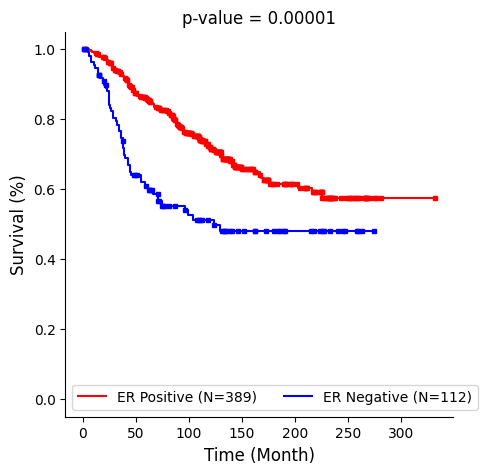

In [26]:
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
clinical_ = clinical[['Disease-specific Survival (Months)', 'Disease-specific Survival Status', 'ER Status']].dropna()
clinical_['Disease-specific Survival Status'] = clinical_['Disease-specific Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
Length_ = clinical_['Disease-specific Survival (Months)'].values
Status_ = clinical_['Disease-specific Survival Status'].values
ER_Status_ = clinical_['ER Status'].values

kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
length_A, event_observed_A = (
            Length_[ER_Status_ == 'Positive'],
            Status_[ER_Status_ == 'Positive'],
        )
label = "ER Positive (N={})".format( np.sum(ER_Status_ == 'Positive'))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='red',
    show_censors=True, censor_styles={"ms": 3, "marker": "s"})

length_B, event_observed_B = (
            Length_[ER_Status_ == 'Negative'],
            Status_[ER_Status_ == 'Negative'],
        )
label = "ER Negative (N={})".format( np.sum(ER_Status_ == 'Negative'))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='blue',
    show_censors=True, censor_styles={"ms": 3, "marker": "s"})

log_rank_test  = logrank_test(length_A, length_B, event_observed_A, event_observed_B)
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

### Heterogeneity

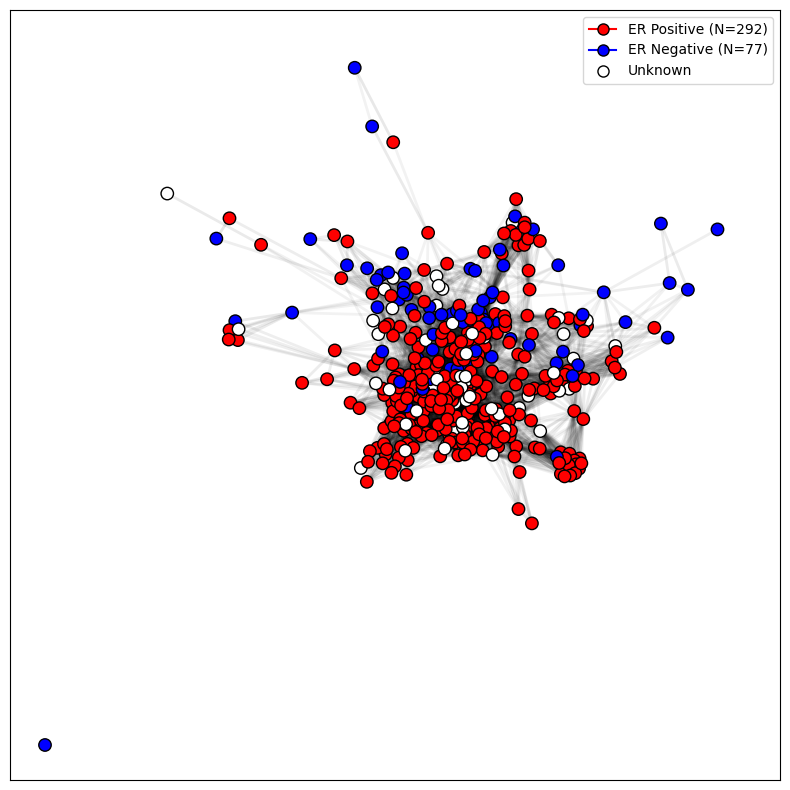

In [39]:
ER_status = np.array(
    [
        clinical.loc[clinical["patient_id"] == patient_id, "ER Status"].values[0]
        for patient_id in Patient_IDs
    ]
)
pos = nx.spring_layout(G_population, seed=2, k=1 / np.sqrt(682) * 5, iterations=100)
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
edge_list = list(G_population.edges())
edge_alpha = [
    0.1 * G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0 else 0
    for u, v in edge_list
]
nx.draw_networkx_edges(G_population, pos, alpha=edge_alpha, width=2)
Node_color = np.array(["white"] * len(ER_status))
Node_color[ER_status == "Positive"] = "red"
Node_color[ER_status == "Negative"] = "blue"
nx.draw_networkx_nodes(
    G_population, pos, node_size=80, node_color=Node_color, edgecolors="black"
)
handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="red",
        label=f"ER Positive (N={np.sum(ER_status == 'Positive')})",
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="blue",
        label=f"ER Negative (N={np.sum(ER_status == 'Negative')})",
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="white",
        label=f"Unknown",
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
]
ax.legend(handles=handles)
plt.show()

292 ER positive patients, averaged Intra-group similarity is 0.21 
77 ER negative patients, averaged Intra-group similarity is 0.16 
averaged Inter-group similarity is 0.14 


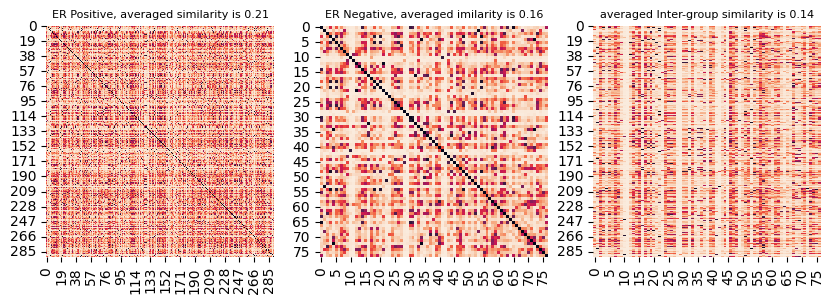

In [7]:

Gram_matrix_pos = Gram_matrix[np.array(np.where(ER_status == 'Positive')[0].tolist()), :][:, np.array(np.where(ER_status == 'Positive')[0].tolist())]
print("{} ER positive patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_pos.shape[0], caculate_mutual_similarity(Gram_matrix_pos)))
# ER Negative
Gram_matrix_neg = Gram_matrix[np.array(np.where(ER_status == 'Negative')[0].tolist()), :][:, np.array(np.where(ER_status == 'Negative')[0].tolist())]
print("{} ER negative patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_neg.shape[0], caculate_mutual_similarity(Gram_matrix_neg)))
# Cross
Gram_matrix_pos_neg = Gram_matrix[np.array(np.where(ER_status == 'Positive')[0].tolist()), :][:, np.array(np.where(ER_status == 'Negative')[0].tolist())]
print("averaged Inter-group similarity is {:.2f} ".format(np.mean(Gram_matrix_pos_neg)))

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3) )
sns.heatmap(
            Gram_matrix_pos,
            ax=ax1,
            cmap="rocket_r",
            edgecolor="black",
            cbar=False,
        )
ax1.set_title("ER Positive, averaged similarity is {:.2f}".format(caculate_mutual_similarity(Gram_matrix_pos)), fontsize=8)
sns.heatmap(
            Gram_matrix_neg,
            ax=ax2,
            cmap="rocket_r",
            edgecolor="black",
            cbar=False,
        )
ax2.set_title("ER Negative, averaged imilarity is {:.2f}".format(caculate_mutual_similarity(Gram_matrix_neg)), fontsize=8)
sns.heatmap(
            Gram_matrix_pos_neg,
            ax=ax3,
            cmap="rocket_r",
            edgecolor="black",
            cbar=False,
        )
ax3.set_title("averaged Inter-group similarity is {:.2f}".format(np.mean(Gram_matrix_pos_neg)), fontsize=8)
plt.show()

### Over-presented patterns

In [8]:
from scipy import stats
Histogram_pos = Histograms[ER_status == "Positive"]
Histogram_neg = Histograms[ER_status == "Negative"]
Overpresented_in_pos = []
Overpresented_in_neg = []
for i in range(Histograms.shape[1]):
    rvsi = Histogram_pos[:, i]
    rvso = Histogram_neg[:, i]
    result = stats.ttest_ind(rvsi, rvso, equal_var=False)
    if result.pvalue < 0.05 / Histograms.shape[1]:
        print("Pattern {}, Mean in pos = {:.0f}, Mean in neg = {:.0f} (p={:.5f})".format(i, np.mean(rvsi), np.mean(rvso), result.pvalue))
        if np.mean(rvsi) > np.mean(rvso):
            Overpresented_in_pos.append(i)
        else:
            Overpresented_in_neg.append(i)
if len(Overpresented_in_pos) == 0:
    print("No pattern is overderpresented in ER-Positive patients")
else:
    print("overderpresented patterns in ER-Positive patients are {}".format(Overpresented_in_pos))
if len(Overpresented_in_neg) == 0:
    print("No pattern is overderpresented in ER-Negative patients")
else:
    print("overderpresented patterns in ER-Negative patients are {}".format(Overpresented_in_neg))

Pattern 2, Mean in pos = 97, Mean in neg = 30 (p=0.00005)
Pattern 6, Mean in pos = 83, Mean in neg = 3 (p=0.00000)
Pattern 7, Mean in pos = 75, Mean in neg = 5 (p=0.00000)
Pattern 15, Mean in pos = 63, Mean in neg = 7 (p=0.00000)
Pattern 21, Mean in pos = 41, Mean in neg = 1 (p=0.00000)
Pattern 25, Mean in pos = 40, Mean in neg = 4 (p=0.00000)
Pattern 26, Mean in pos = 36, Mean in neg = 4 (p=0.00000)
Pattern 27, Mean in pos = 34, Mean in neg = 4 (p=0.00000)
Pattern 28, Mean in pos = 32, Mean in neg = 9 (p=0.00000)
Pattern 31, Mean in pos = 32, Mean in neg = 1 (p=0.00000)
Pattern 35, Mean in pos = 22, Mean in neg = 0 (p=0.00000)
overderpresented patterns in ER-Positive patients are [2, 6, 7, 15, 21, 25, 26, 27, 28, 31, 35]
No pattern is overderpresented in ER-Negative patients


(64, 32)


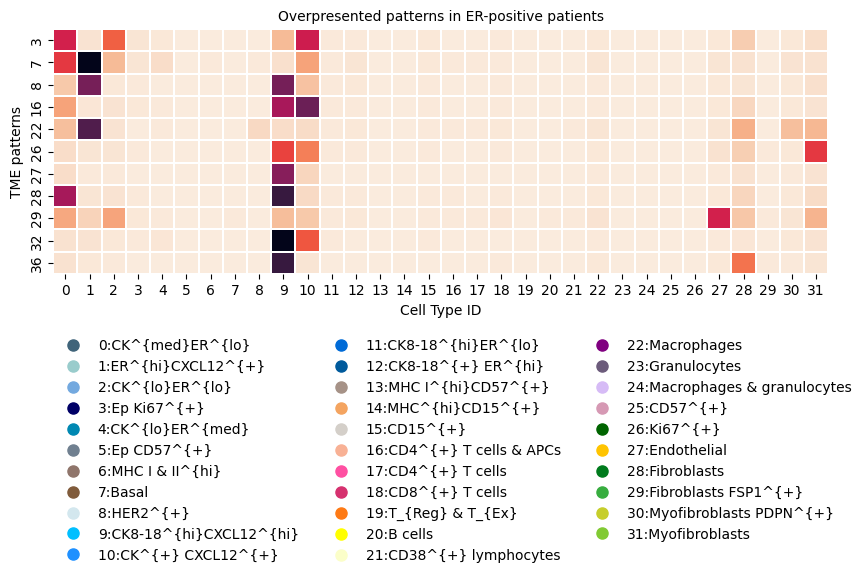

In [9]:
from b_Soft_WL_Kernel.SoftWL import compute_cluster_centroids
Centroids = compute_cluster_centroids(X, Cluster_identities)
print(Centroids.shape)
if len(Overpresented_in_pos) > 0:
    f, (ax1, ax2) = plt.subplots(2,1,figsize=(10,7) )
    sns.heatmap(
                Centroids[Overpresented_in_pos, :],
                ax=ax1,
                cbar = False,
                cmap="rocket_r",
                linewidth=0.005,
                edgecolor="black",
                vmax=np.percentile(Centroids, 99),
                vmin=np.percentile(Centroids, 1),
            )
    ax1.set_yticklabels([i+1 for i in Overpresented_in_pos], fontsize=10)
    ax1.set_ylabel("TME patterns", fontsize=10)
    ax1.set_xlabel("Cell Type ID", fontsize=10)
    ax1.set_title("Overpresented patterns in ER-positive patients", fontsize=10)

    from definitions import get_cell_color, get_cell_phenotype_id
    cell_color_dict = get_cell_color("Danenberg")
    cell_type_dict = get_cell_phenotype_id("Danenberg")
    func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
    cell_types = [str(cell_type_id)+':'+cell_type for cell_type, cell_type_id in cell_type_dict.items()]
    colors = [cell_color_dict[cell_type] for cell_type, cell_type_id in cell_type_dict.items()]
    handles = [func("o", colors[i]) for i in range(len(cell_types))]
    ax2.legend(
            handles,
            cell_types,
            loc=3,
            framealpha=0,
            frameon=1,
            ncols=3,
            borderaxespad=0.0,
            fontsize=10,
        )
    ax2.axis("off")
    plt.show()
if len(Overpresented_in_neg) > 0:
    f, (ax1, ax2) = plt.subplots(2,1,figsize=(10,7) )
    sns.heatmap(
                Centroids[Overpresented_in_neg, :],
                ax=ax1,
                cbar = False,
                cmap="rocket_r",
                linewidth=0.005,
                edgecolor="black",
                vmax=np.percentile(Centroids, 99),
                vmin=np.percentile(Centroids, 1),
            )
    ax1.set_yticklabels([i+1 for i in Overpresented_in_pos], fontsize=10)
    ax1.set_ylabel("TME patterns", fontsize=10)
    ax1.set_xlabel("Cell Type ID", fontsize=10)
    ax1.set_title("Overpresented patterns in ER-negative patients", fontsize=10)

    from definitions import get_cell_color, get_cell_phenotype_id
    cell_color_dict = get_cell_color("Danenberg")
    cell_type_dict = get_cell_phenotype_id("Danenberg")
    func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
    cell_types = [str(cell_type_id)+':'+cell_type for cell_type, cell_type_id in cell_type_dict.items()]
    colors = [cell_color_dict[cell_type] for cell_type, cell_type_id in cell_type_dict.items()]
    handles = [func("o", colors[i]) for i in range(len(cell_types))]
    ax2.legend(
            handles,
            cell_types,
            loc=3,
            framealpha=0,
            frameon=1,
            ncols=3,
            borderaxespad=0.0,
            fontsize=10,
        )
    ax2.axis("off")
    plt.show()


# PR Status

### Survival

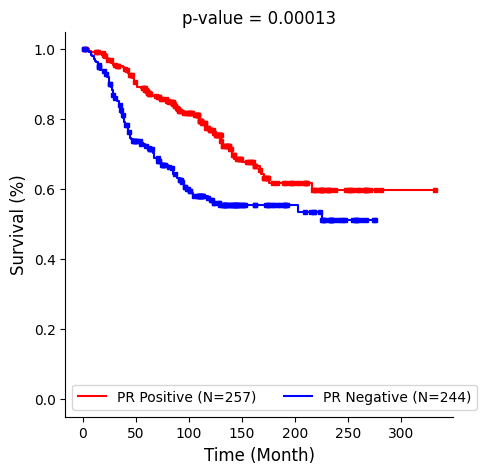

In [29]:
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
clinical_ = clinical[['Disease-specific Survival (Months)', 'Disease-specific Survival Status', 'PR Status']].dropna()
clinical_['Disease-specific Survival Status'] = clinical_['Disease-specific Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
Length_ = clinical_['Disease-specific Survival (Months)'].values
Status_ = clinical_['Disease-specific Survival Status'].values
PR_Status_ = clinical_['PR Status'].values

kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
length_A, event_observed_A = (
            Length_[PR_Status_ == 'Positive'],
            Status_[PR_Status_ == 'Positive'],
        )
label = "PR Positive (N={})".format( np.sum(PR_Status_ == 'Positive'))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='red',
    show_censors=True, censor_styles={"ms": 3, "marker": "s"})

length_B, event_observed_B = (
            Length_[PR_Status_ == 'Negative'],
            Status_[PR_Status_ == 'Negative'],
        )
label = "PR Negative (N={})".format( np.sum(PR_Status_ == 'Negative'))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='blue',
    show_censors=True, censor_styles={"ms": 3, "marker": "s"})

log_rank_test  = logrank_test(length_A, length_B, event_observed_A, event_observed_B)
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

### Heterogeneity

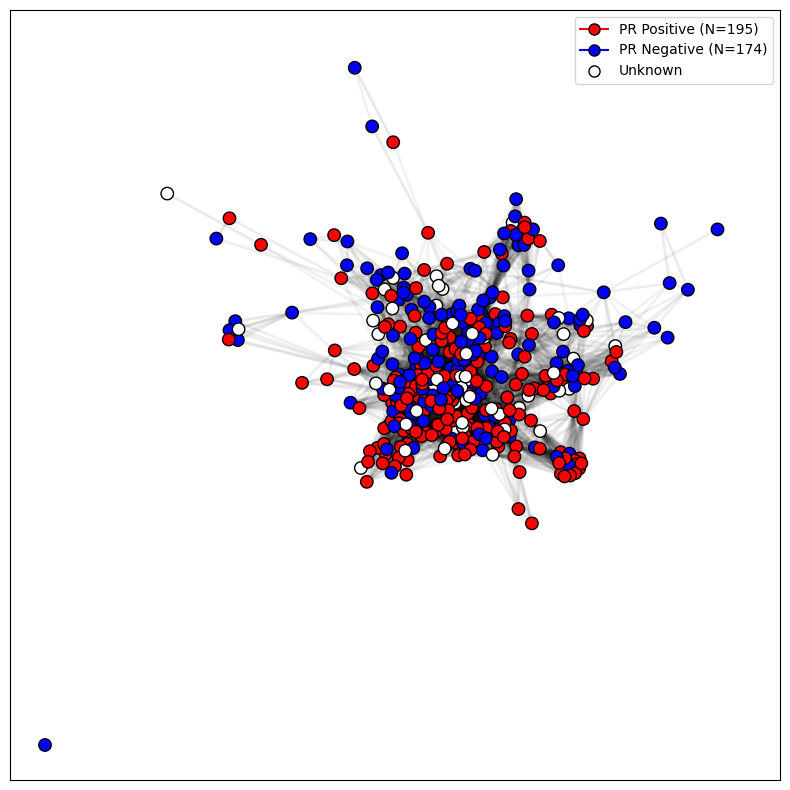

In [41]:
PR_status = np.array(
    [
        clinical.loc[clinical["patient_id"] == patient_id, "PR Status"].values[0]
        for patient_id in Patient_IDs
    ]
)
pos = nx.spring_layout(G_population, seed=2, k=1 / np.sqrt(682) * 5, iterations=100)
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
edge_list = list(G_population.edges())
edge_alpha = [
    0.1 * G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0 else 0
    for u, v in edge_list
]
nx.draw_networkx_edges(G_population, pos, alpha=edge_alpha, width=2)
Node_color = np.array(["white"] * len(PR_status))
Node_color[PR_status == "Positive"] = "red"
Node_color[PR_status == "Negative"] = "blue"
nx.draw_networkx_nodes(
    G_population, pos, node_size=80, node_color=Node_color, edgecolors="black"
)
handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="red",
        label=f"PR Positive (N={np.sum(PR_status == 'Positive')})",
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="blue",
        label=f"PR Negative (N={np.sum(PR_status == 'Negative')})",
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="white",
        label=f"Unknown",
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
]
ax.legend(handles=handles)
plt.show()

195 PR positive patients, averaged Intra-group similarity is 0.20 
174 PR negative patients, averaged Intra-group similarity is 0.17 
averaged Inter-group similarity is 0.18 


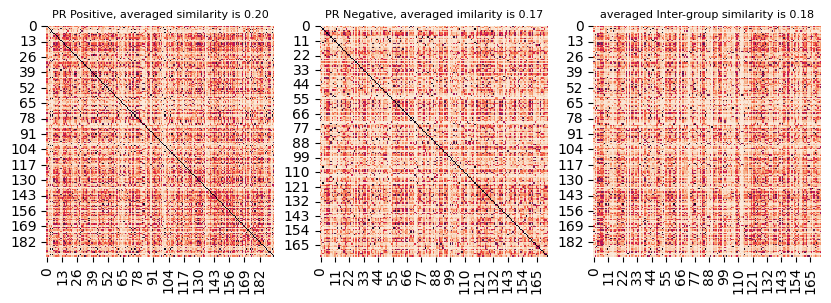

In [10]:
PR_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'PR Status'].values[0] for patient_id in Patient_IDs])
# ER Positive
Gram_matrix_pos = Gram_matrix[np.array(np.where(PR_status == 'Positive')[0].tolist()), :][:, np.array(np.where(PR_status == 'Positive')[0].tolist())]
print("{} PR positive patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_pos.shape[0], caculate_mutual_similarity(Gram_matrix_pos)))
# ER Negative
Gram_matrix_neg = Gram_matrix[np.array(np.where(PR_status == 'Negative')[0].tolist()), :][:, np.array(np.where(PR_status == 'Negative')[0].tolist())]
print("{} PR negative patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_neg.shape[0], caculate_mutual_similarity(Gram_matrix_neg)))
# Cross
Gram_matrix_pos_neg = Gram_matrix[np.array(np.where(PR_status == 'Positive')[0].tolist()), :][:, np.array(np.where(PR_status == 'Negative')[0].tolist())]
print("averaged Inter-group similarity is {:.2f} ".format(np.mean(Gram_matrix_pos_neg)))

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3) )
sns.heatmap(
            Gram_matrix_pos,
            ax=ax1,
            cmap="rocket_r",
            edgecolor="black",
            cbar=False,
        )
ax1.set_title("PR Positive, averaged similarity is {:.2f}".format(caculate_mutual_similarity(Gram_matrix_pos)), fontsize=8)
sns.heatmap(
            Gram_matrix_neg,
            ax=ax2,
            cmap="rocket_r",
            edgecolor="black",
            cbar=False,
        )
ax2.set_title("PR Negative, averaged imilarity is {:.2f}".format(caculate_mutual_similarity(Gram_matrix_neg)), fontsize=8)
sns.heatmap(
            Gram_matrix_pos_neg,
            ax=ax3,
            cmap="rocket_r",
            edgecolor="black",
            cbar=False,
        )
ax3.set_title("averaged Inter-group similarity is {:.2f}".format(np.mean(Gram_matrix_pos_neg)), fontsize=8)
plt.show()

### Over-presented patterns

In [22]:
from scipy import stats
Histogram_pos = Histograms[PR_status == "Positive"]
Histogram_neg = Histograms[PR_status == "Negative"]
Overpresented_in_pos = []
Overpresented_in_neg = []
for i in range(Histograms.shape[1]):
    rvsi = Histogram_pos[:, i]
    rvso = Histogram_neg[:, i]
    result = stats.ttest_ind(rvsi, rvso, equal_var=False)
    if result.pvalue < 0.05 / Histograms.shape[1]:
        print("Pattern {}, Mean in pos = {:.0f}, Mean in neg = {:.0f} (p={:.5f})".format(i, np.mean(rvsi), np.mean(rvso), result.pvalue))
        if np.mean(rvsi) > np.mean(rvso):
            Overpresented_in_pos.append(i)
        else:
            Overpresented_in_neg.append(i)
if len(Overpresented_in_pos) == 0:
    print("No pattern is overderpresented in PR-Positive patients")
else:
    print("overderpresented patterns in PR-Positive patients are {}".format(Overpresented_in_pos))
if len(Overpresented_in_neg) == 0:
    print("No pattern is overderpresented in PR-Negative patients")
else:
    print("overderpresented patterns in PR-Negative patients are {}".format(Overpresented_in_neg))

Pattern 25, Mean in pos = 48, Mean in neg = 14 (p=0.00000)
overderpresented patterns in PR-Positive patients are [25]
No pattern is overderpresented in PR-Negative patients


(64, 32)


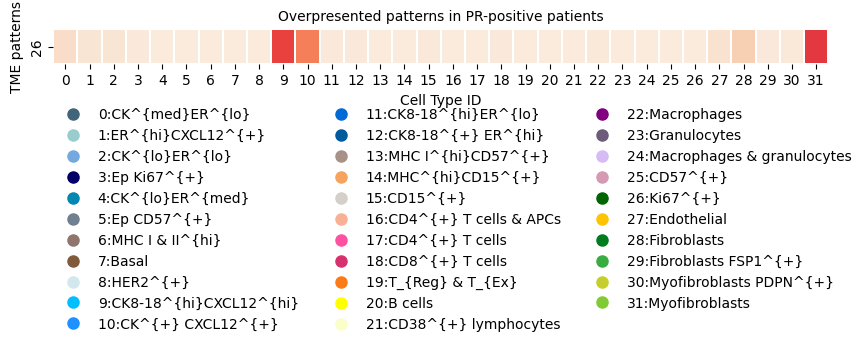

In [20]:
from b_Soft_WL_Kernel.SoftWL import compute_cluster_centroids
Centroids = compute_cluster_centroids(X, Cluster_identities)
print(Centroids.shape)
if len(Overpresented_in_pos) > 0:
    f, (ax1, ax2) = plt.subplots(2,1,figsize=(10,4), gridspec_kw= {"height_ratios": [1,7]})
    sns.heatmap(
                Centroids[Overpresented_in_pos, :],
                ax=ax1,
                cbar = False,
                cmap="rocket_r",
                linewidth=0.005,
                edgecolor="black",
                vmax=np.percentile(Centroids, 99),
                vmin=np.percentile(Centroids, 1),
            )
    ax1.set_yticklabels([i+1 for i in Overpresented_in_pos], fontsize=10)
    ax1.set_ylabel("TME patterns", fontsize=10)
    ax1.set_xlabel("Cell Type ID", fontsize=10)
    ax1.set_title("Overpresented patterns in PR-positive patients", fontsize=10)

    from definitions import get_cell_color, get_cell_phenotype_id
    cell_color_dict = get_cell_color("Danenberg")
    cell_type_dict = get_cell_phenotype_id("Danenberg")
    func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
    cell_types = [str(cell_type_id)+':'+cell_type for cell_type, cell_type_id in cell_type_dict.items()]
    colors = [cell_color_dict[cell_type] for cell_type, cell_type_id in cell_type_dict.items()]
    handles = [func("o", colors[i]) for i in range(len(cell_types))]
    ax2.legend(
            handles,
            cell_types,
            loc=3,
            framealpha=0,
            frameon=1,
            ncols=3,
            borderaxespad=0.0,
            fontsize=10,
        )
    ax2.axis("off")
    plt.show()
if len(Overpresented_in_neg) > 0:
    f, (ax1, ax2) = plt.subplots(2,1,figsize=(10,7) )
    sns.heatmap(
                Centroids[Overpresented_in_neg, :],
                ax=ax1,
                cbar = False,
                cmap="rocket_r",
                linewidth=0.005,
                edgecolor="black",
                vmax=np.percentile(Centroids, 99),
                vmin=np.percentile(Centroids, 1),
            )
    ax1.set_yticklabels([i+1 for i in Overpresented_in_neg], fontsize=10)
    ax1.set_ylabel("TME patterns", fontsize=10)
    ax1.set_xlabel("Cell Type ID", fontsize=10)
    ax1.set_title("Overpresented patterns in PR-negative patients", fontsize=10)

    from definitions import get_cell_color, get_cell_phenotype_id
    cell_color_dict = get_cell_color("Danenberg")
    cell_type_dict = get_cell_phenotype_id("Danenberg")
    func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
    cell_types = [str(cell_type_id)+':'+cell_type for cell_type, cell_type_id in cell_type_dict.items()]
    colors = [cell_color_dict[cell_type] for cell_type, cell_type_id in cell_type_dict.items()]
    handles = [func("o", colors[i]) for i in range(len(cell_types))]
    ax2.legend(
            handles,
            cell_types,
            loc=3,
            framealpha=0,
            frameon=1,
            ncols=3,
            borderaxespad=0.0,
            fontsize=10,
        )
    ax2.axis("off")
    plt.show()


# HER2 Status

### Survival

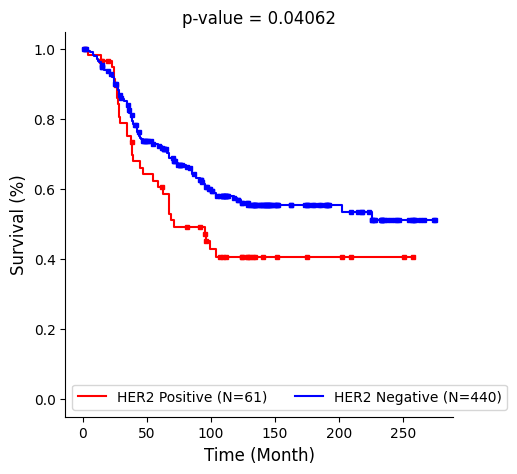

In [31]:
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test
clinical_ = clinical[['Disease-specific Survival (Months)', 'Disease-specific Survival Status', 'HER2 Status']].dropna()
clinical_['Disease-specific Survival Status'] = clinical_['Disease-specific Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
Length_ = clinical_['Disease-specific Survival (Months)'].values
Status_ = clinical_['Disease-specific Survival Status'].values
HER2_Status_ = clinical_['HER2 Status'].values

kmf = KaplanMeierFitter()
f, ax = plt.subplots(figsize=(5, 5))
length_A, event_observed_A = (
            Length_[HER2_Status_ == 'Positive'],
            Status_[HER2_Status_ == 'Positive'],
        )
label = "HER2 Positive (N={})".format( np.sum(HER2_Status_ == 'Positive'))
kmf.fit(length_A, event_observed_A, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='red',
    show_censors=True, censor_styles={"ms": 3, "marker": "s"})

length_B, event_observed_B = (
            Length_[PR_Status_ == 'Negative'],
            Status_[PR_Status_ == 'Negative'],
        )
label = "HER2 Negative (N={})".format( np.sum(HER2_Status_ == 'Negative'))
kmf.fit(length_B, event_observed_B, label=label)
kmf.plot_survival_function(ax=ax, ci_show=False, color='blue',
    show_censors=True, censor_styles={"ms": 3, "marker": "s"})

log_rank_test  = logrank_test(length_A, length_B, event_observed_A, event_observed_B)
p_value = log_rank_test.p_value
ax.legend(ncol=2, fontsize = 10)
ax.set_title("p-value = {:.5f}".format(p_value), fontsize = 12)
ax.set_xlabel("Time (Month)", fontsize = 12)
ax.set_ylabel("Survival (%)", fontsize = 12)
ax.set(
        ylim=(-0.05, 1.05),
    )
sns.despine()

### Heterogeneity

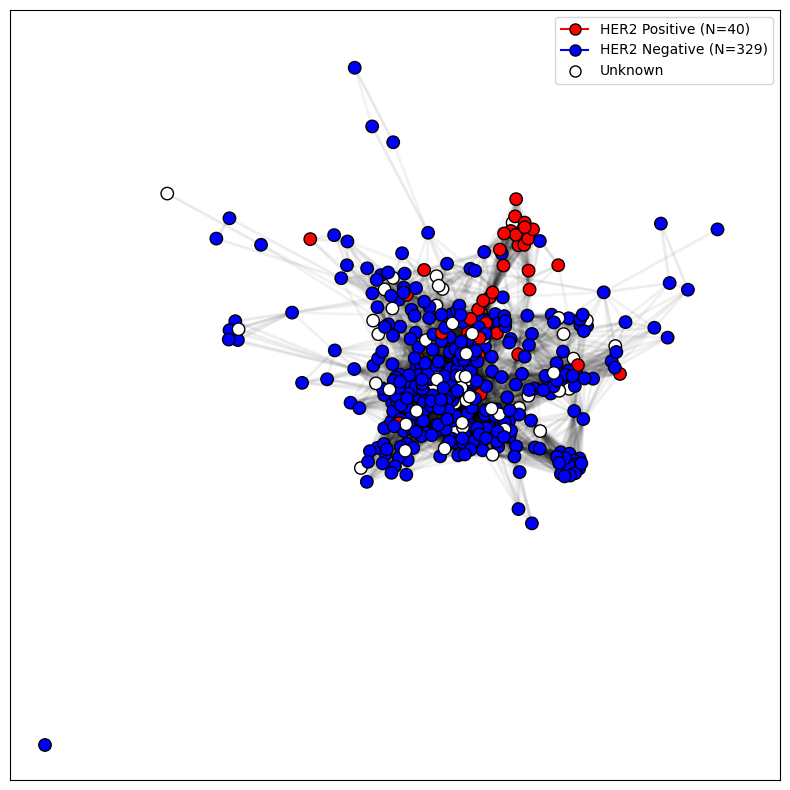

In [43]:
HER2_status = np.array(
    [
        clinical.loc[clinical["patient_id"] == patient_id, "HER2 Status"].values[0]
        for patient_id in Patient_IDs
    ]
)
pos = nx.spring_layout(G_population, seed=2, k=1 / np.sqrt(682) * 5, iterations=100)
fig, ax = plt.subplots(figsize=(8, 8), tight_layout=True)
edge_list = list(G_population.edges())
edge_alpha = [
    0.1 * G_population[u][v]["weight"] if G_population[u][v]["weight"] > 0 else 0
    for u, v in edge_list
]
nx.draw_networkx_edges(G_population, pos, alpha=edge_alpha, width=2)
Node_color = np.array(["white"] * len(HER2_status))
Node_color[HER2_status == "Positive"] = "red"
Node_color[HER2_status == "Negative"] = "blue"
nx.draw_networkx_nodes(
    G_population, pos, node_size=80, node_color=Node_color, edgecolors="black"
)
handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="red",
        label=f"HER2 Positive (N={np.sum(HER2_status == 'Positive')})",
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="blue",
        label=f"HER2 Negative (N={np.sum(HER2_status == 'Negative')})",
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
    Line2D(
        [0],
        [0],
        marker="o",
        color="white",
        label=f"Unknown",
        markeredgecolor="black",
        markeredgewidth=1,
        markersize=8,
    ),
]
ax.legend(handles=handles)
plt.show()

40 HER2 positive patients, averaged Intra-group similarity is 0.34 
329 HER2 negative patients, averaged Intra-group similarity is 0.19 
averaged Inter-group similarity is 0.14 


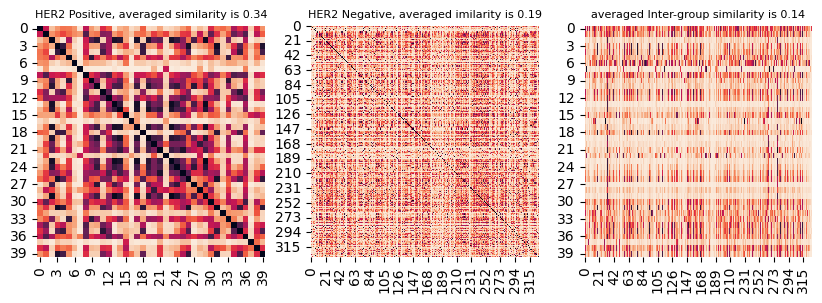

In [11]:
HER2_status = np.array([clinical.loc[clinical['patient_id'] == patient_id, 'HER2 Status'].values[0] for patient_id in Patient_IDs])
# ER Positive
Gram_matrix_pos = Gram_matrix[np.array(np.where(HER2_status == 'Positive')[0].tolist()), :][:, np.array(np.where(HER2_status == 'Positive')[0].tolist())]
print("{} HER2 positive patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_pos.shape[0], caculate_mutual_similarity(Gram_matrix_pos)))
# ER Negative
Gram_matrix_neg = Gram_matrix[np.array(np.where(HER2_status == 'Negative')[0].tolist()), :][:, np.array(np.where(HER2_status == 'Negative')[0].tolist())]
print("{} HER2 negative patients, averaged Intra-group similarity is {:.2f} ".format(Gram_matrix_neg.shape[0], caculate_mutual_similarity(Gram_matrix_neg)))
# Cross
Gram_matrix_pos_neg = Gram_matrix[np.array(np.where(HER2_status == 'Positive')[0].tolist()), :][:, np.array(np.where(HER2_status == 'Negative')[0].tolist())]
print("averaged Inter-group similarity is {:.2f} ".format(np.mean(Gram_matrix_pos_neg)))

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10,3) )
sns.heatmap(
            Gram_matrix_pos,
            ax=ax1,
            cmap="rocket_r",
            edgecolor="black",
            cbar=False,
        )
ax1.set_title("HER2 Positive, averaged similarity is {:.2f}".format(caculate_mutual_similarity(Gram_matrix_pos)), fontsize=8)
sns.heatmap(
            Gram_matrix_neg,
            ax=ax2,
            cmap="rocket_r",
            edgecolor="black",
            cbar=False,
        )
ax2.set_title("HER2 Negative, averaged imilarity is {:.2f}".format(caculate_mutual_similarity(Gram_matrix_neg)), fontsize=8)
sns.heatmap(
            Gram_matrix_pos_neg,
            ax=ax3,
            cmap="rocket_r",
            edgecolor="black",
            cbar=False,
        )
ax3.set_title("averaged Inter-group similarity is {:.2f}".format(np.mean(Gram_matrix_pos_neg)), fontsize=8)
plt.show()

### Over-presented patterns

In [23]:
from scipy import stats
Histogram_pos = Histograms[HER2_status == "Positive"]
Histogram_neg = Histograms[HER2_status == "Negative"]
Overpresented_in_pos = []
Overpresented_in_neg = []
for i in range(Histograms.shape[1]):
    rvsi = Histogram_pos[:, i]
    rvso = Histogram_neg[:, i]
    result = stats.ttest_ind(rvsi, rvso, equal_var=False)
    if result.pvalue < 0.05 / Histograms.shape[1]:
        print("Pattern {}, Mean in pos = {:.0f}, Mean in neg = {:.0f} (p={:.5f})".format(i, np.mean(rvsi), np.mean(rvso), result.pvalue))
        if np.mean(rvsi) > np.mean(rvso):
            Overpresented_in_pos.append(i)
        else:
            Overpresented_in_neg.append(i)
if len(Overpresented_in_pos) == 0:
    print("No pattern is overderpresented in HER2-Positive patients")
else:
    print("overderpresented patterns in HER2-Positive patients are {}".format(Overpresented_in_pos))
if len(Overpresented_in_neg) == 0:
    print("No pattern is overderpresented in HER2-Negative patients")
else:
    print("overderpresented patterns in HER2-Negative patients are {}".format(Overpresented_in_neg))

Pattern 2, Mean in pos = 10, Mean in neg = 92 (p=0.00000)
Pattern 4, Mean in pos = 2, Mean in neg = 87 (p=0.00000)
Pattern 6, Mean in pos = 7, Mean in neg = 73 (p=0.00000)
Pattern 7, Mean in pos = 3, Mean in neg = 67 (p=0.00000)
Pattern 15, Mean in pos = 2, Mean in neg = 57 (p=0.00000)
Pattern 22, Mean in pos = 279, Mean in neg = 9 (p=0.00012)
Pattern 23, Mean in pos = 4, Mean in neg = 39 (p=0.00010)
Pattern 26, Mean in pos = 5, Mean in neg = 32 (p=0.00004)
Pattern 27, Mean in pos = 3, Mean in neg = 31 (p=0.00000)
Pattern 28, Mean in pos = 12, Mean in neg = 29 (p=0.00000)
Pattern 31, Mean in pos = 1, Mean in neg = 29 (p=0.00000)
Pattern 35, Mean in pos = 2, Mean in neg = 20 (p=0.00004)
overderpresented patterns in HER2-Positive patients are [22]
overderpresented patterns in HER2-Negative patients are [2, 4, 6, 7, 15, 23, 26, 27, 28, 31, 35]


(64, 32)


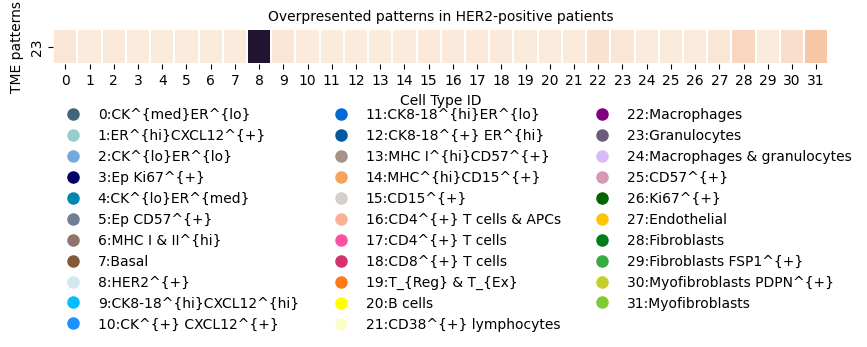

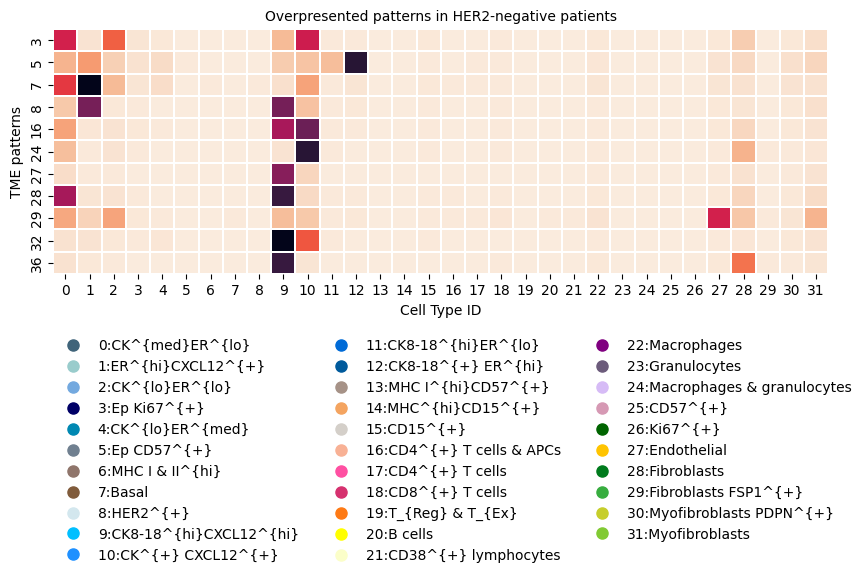

In [26]:
from b_Soft_WL_Kernel.SoftWL import compute_cluster_centroids
Centroids = compute_cluster_centroids(X, Cluster_identities)
print(Centroids.shape)
if len(Overpresented_in_pos) > 0:
    f, (ax1, ax2) = plt.subplots(2,1,figsize=(10,4), gridspec_kw= {"height_ratios": [1,7]})
    sns.heatmap(
                Centroids[Overpresented_in_pos, :],
                ax=ax1,
                cbar = False,
                cmap="rocket_r",
                linewidth=0.005,
                edgecolor="black",
                vmax=np.percentile(Centroids, 99),
                vmin=np.percentile(Centroids, 1),
            )
    ax1.set_yticklabels([i+1 for i in Overpresented_in_pos], fontsize=10)
    ax1.set_ylabel("TME patterns", fontsize=10)
    ax1.set_xlabel("Cell Type ID", fontsize=10)
    ax1.set_title("Overpresented patterns in HER2-positive patients", fontsize=10)

    from definitions import get_cell_color, get_cell_phenotype_id
    cell_color_dict = get_cell_color("Danenberg")
    cell_type_dict = get_cell_phenotype_id("Danenberg")
    func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
    cell_types = [str(cell_type_id)+':'+cell_type for cell_type, cell_type_id in cell_type_dict.items()]
    colors = [cell_color_dict[cell_type] for cell_type, cell_type_id in cell_type_dict.items()]
    handles = [func("o", colors[i]) for i in range(len(cell_types))]
    ax2.legend(
            handles,
            cell_types,
            loc=3,
            framealpha=0,
            frameon=1,
            ncols=3,
            borderaxespad=0.0,
            fontsize=10,
        )
    ax2.axis("off")
    plt.show()
if len(Overpresented_in_neg) > 0:
    f, (ax1, ax2) = plt.subplots(2,1,figsize=(10,7) )
    sns.heatmap(
                Centroids[Overpresented_in_neg, :],
                ax=ax1,
                cbar = False,
                cmap="rocket_r",
                linewidth=0.005,
                edgecolor="black",
                vmax=np.percentile(Centroids, 99),
                vmin=np.percentile(Centroids, 1),
            )
    ax1.set_yticklabels([i+1 for i in Overpresented_in_neg], fontsize=10)
    ax1.set_ylabel("TME patterns", fontsize=10)
    ax1.set_xlabel("Cell Type ID", fontsize=10)
    ax1.set_title("Overpresented patterns in HER2-negative patients", fontsize=10)

    from definitions import get_cell_color, get_cell_phenotype_id
    cell_color_dict = get_cell_color("Danenberg")
    cell_type_dict = get_cell_phenotype_id("Danenberg")
    func = lambda m, c: plt.plot([], [], marker=m, color=c, ls="none", markersize=8)[0]
    cell_types = [str(cell_type_id)+':'+cell_type for cell_type, cell_type_id in cell_type_dict.items()]
    colors = [cell_color_dict[cell_type] for cell_type, cell_type_id in cell_type_dict.items()]
    handles = [func("o", colors[i]) for i in range(len(cell_types))]
    ax2.legend(
            handles,
            cell_types,
            loc=3,
            framealpha=0,
            frameon=1,
            ncols=3,
            borderaxespad=0.0,
            fontsize=10,
        )
    ax2.axis("off")
    plt.show()
